# Hourly trends

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import datetime
import os
import re
import matplotlib.dates as mdates
from IPython.display import display
from copy import deepcopy

Plot the timeframes retrieved for one keyword

In [2]:
topics = {
    'Mal de gorge': '/m/0b76bty',
}

topic_used = 'Mal de gorge'
topic_code = topics[topic_used]
data_hourly_dir = "../data/trends/collect"
geo = "FR-D"
date_parser = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
df_hourly = {name: pd.read_csv(f"{data_hourly_dir}/{geo}-{name}.csv", parse_dates=['date'], date_parser=date_parser).set_index('date') for name in topics}
df_hourly[topic_used]

,/m/0b76bty,batch_id
date,,
2020-02-01 00:00:00,22.0,0
2020-02-01 01:00:00,58.0,0
2020-02-01 02:00:00,25.0,0
2020-02-01 03:00:00,53.0,0
2020-02-01 04:00:00,0.0,0
...,...,...
2021-02-10 19:00:00,4.0,50
2021-02-10 20:00:00,12.0,50
2021-02-10 21:00:00,11.0,50


## All hourly batches retrieved

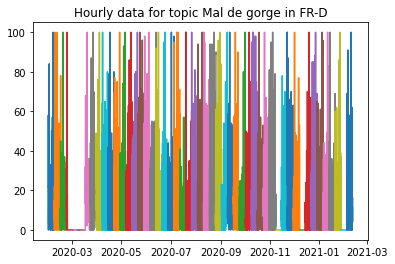

In [3]:
batch_id = df_hourly[topic_used]["batch_id"].unique()
plt.figure()
for i in batch_id:
    df = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == i]
    plt.plot(df[topics[topic_used]])
plt.title(f"Hourly data for topic {topic_used} in {geo}")
plt.show()

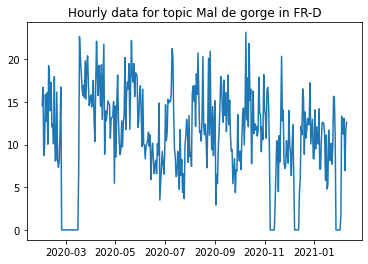

In [4]:
df_hourly_agg = {k: df_hourly[k].resample('D').mean() for k in topics}
plt.figure()
plt.plot(df_hourly_agg[topic_used][topics[topic_used]])
plt.title(f"Hourly data for topic {topic_used} in {geo}")
plt.show()

In [5]:
def merge_trends_batches(left, right, overlap_time, topic, isHour=True, verbose=False, drop=None):
    """
    return the concatenation of left and right, correctly scaled based on their overlap (in hours or days)

    :param left: accumulator dataframe
    :param right: new dataframe to add to the accumulator
    :param overlap_hour: number of hours that are overlapping
    :param topic: topic considered
    :param isHour: if true, the overlap is computed in hours. Else in days
    :param verbose: True if information must be printed
    :param drop: can be one of None, 'left' or 'right'. The function can choose to keep scaled values 
        from left or right on the intersection. If drop == left -> keep the right values, if drop == right ->
        keep the left values. Else take whatever value.
    """
    if left.empty:
        return right
    # retrieve the overlapping points:
    overlap_start = right.index.min()
    if isHour:
        overlap_end = overlap_start + datetime.timedelta(hours=overlap_time - 1)
    else:
        overlap_end = overlap_start + datetime.timedelta(days=overlap_time - 1)
    left_overlap = left[overlap_start:overlap_end]
    right_overlap = right[overlap_start:overlap_end]
    scaling_full = (left_overlap[topic] / right_overlap[topic]).replace([np.inf, -np.inf], np.nan).dropna()
    if verbose:
        print('overlap left:', left_overlap[topic])
        print('overlap right:', right_overlap[topic])
        print('ratio:', scaling_full)
        print("my drop=",drop)
    scaling = scaling_full.mean()
    if scaling < 1:  # right has not the good scale
        if drop == 'left':
            left_to_keep = left[left.index < overlap_start]
            right_to_add = right * scaling
            return left_to_keep.append(right_to_add)
        else:
            right_to_add = right[right.index > overlap_end]
            right_to_add = right_to_add * scaling
            return left.append(right_to_add)
    else:  # left has not the good scale
        if drop == 'right':
            right_to_keep = right[right.index > overlap_end]
            left_to_add = left / scaling
            return left_to_add.append(right_to_keep)
        else:
            left_to_add = left[left.index < overlap_start]
            left_to_add = left_to_add / scaling
            return left_to_add.append(right)
    
def scale_df(df, topic):
    """
    Return a list of the scaled df. If there is always an overlap, the list contains one df.
    Otherwhise, the list contains as many df as there are clusters of periods without missing data
    Each df has its first datetime beginning at 0h and its last datetime ending at 23h
    a DataFrame considered as not valid if its id is < 0
    """
    batch_id = df["batch_id"].to_list()
    def f7(seq):
        seen = set()
        seen_add = seen.add
        return [x for x in seq if not (x in seen or seen_add(x))]
    batch_id = f7(batch_id)
    list_scaled_df = []
    scaled_df = pd.DataFrame()
    for i, j in enumerate(batch_id):
        if j < 0:  # the batch id was not valid
            if not scaled_df.empty:
                list_scaled_df.append(scaled_df)
            scaled_df = pd.DataFrame()
            continue
        
        batch_df = df[df["batch_id"] == j].drop(columns=["batch_id"])
        index_overlap = scaled_df.index.intersection(batch_df.index)
        overlap_hours = len(index_overlap)
        overlap_left = scaled_df.loc[index_overlap]
        overlap_right = batch_df.loc[index_overlap]
        if overlap_hours == 0 and scaled_df.empty:
            scaled_df = merge_trends_batches(scaled_df, batch_df, overlap_hours, topic)
        elif (overlap_left[topic] * overlap_right[topic]).sum() == 0: # cannot perform the merge
            list_scaled_df.append(scaled_df)
            scaled_df = batch_df
        else:
            scaled_df = merge_trends_batches(scaled_df, batch_df, overlap_hours, topic)
    list_scaled_df.append(scaled_df)
    
    # drop the periods at the beginning and the end, in order to cover YYYY-MM-DD:00h -> YYYY-MM-DD:23h
    for i in range(len(list_scaled_df)):
        df = list_scaled_df[i]
        old_begin, old_end = df.index.min(), df.index.max()
        new_begin = old_begin + datetime.timedelta(hours=((24-old_begin.hour)%24))
        new_end = old_end - datetime.timedelta(hours=((old_end.hour+1)%24))
        list_scaled_df[i] = df[new_begin:new_end]
    return list_scaled_df

## Scaling test

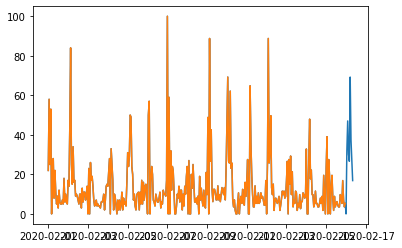

In [6]:
df_1 = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == 0]
df_2 = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == 1]
overlap = len(df_1.index.intersection(df_2.index))
inter = df_1.index.intersection(df_2.index)
plt.plot(merge_trends_batches(df_1, df_2, overlap, topic_code)[topic_code])
df_test = df_hourly[topic_used][(df_hourly[topic_used]["batch_id"] == 0) | (df_hourly[topic_used]["batch_id"] == 1)]
df_test = scale_df(df_test, topic_code)
plt.plot(df_test[0][topic_code])

## Real test: scale and aggregate hourly data

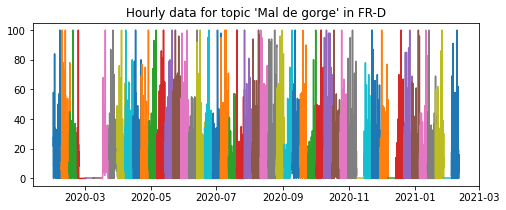

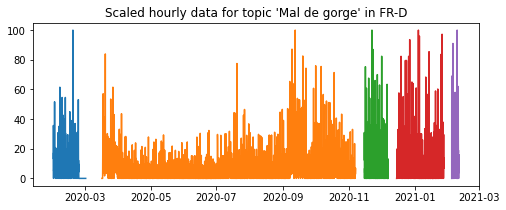

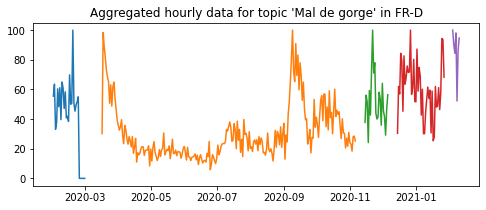

In [7]:
plt.figure(figsize=(8,3))
for i in batch_id:
    df = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == i]
    plt.plot(df[topics[topic_used]])
plt.title(f"Hourly data for topic '{topic_used}' in {geo}")
#plt.savefig("hourly.png", dpi=300)
plt.show()
plt.figure(figsize=(8,3))

scaled_df = scale_df(df_hourly[topic_used], topic_code)
for df in scaled_df:
    plt.plot(df[topic_code])
plt.title(f"Scaled hourly data for topic '{topic_used}' in {geo}")
#plt.savefig("hourly_scaled.png", dpi=300)
plt.show()

plt.figure(figsize=(8,3))
for df in scaled_df:
    values = df[topic_code].resample('D').mean()
    plt.plot(values * 100 / max(values))
plt.title(f"Aggregated hourly data for topic '{topic_used}' in {geo}")
#plt.savefig("hourly_aggregated.png", dpi=300)
plt.show()

# Retrieve missing days needed for normalization
Read the dataframe and return the list of timeframe needed in order to normalize the whole dataframe

In [9]:
def timeframe_normalize_clusters(list_df, overlap_days=5):
    """
    take as input the list of df given by scale_df and return the list of dates needed to normalize 
    the whole set of data, as tuple of dates
    """
    list_tf = []
    delta = datetime.timedelta(days=overlap_days)
    for df_i, df_j in zip(list_df, list_df[1:]):
        begin = (df_i.index.max() - delta).to_pydatetime()
        end = (df_j.index.min() + delta).to_pydatetime()
        list_tf.append((begin, end))
    return list_tf
print(timeframe_normalize_clusters(scaled_df))

[(datetime.datetime(2020, 2, 25, 23, 0), datetime.datetime(2020, 3, 22, 0, 0)), (datetime.datetime(2020, 10, 18, 23, 0), datetime.datetime(2020, 10, 29, 0, 0)), (datetime.datetime(2020, 12, 1, 23, 0), datetime.datetime(2020, 12, 20, 0, 0)), (datetime.datetime(2020, 12, 31, 23, 0), datetime.datetime(2021, 1, 18, 0, 0)), (datetime.datetime(2021, 1, 22, 23, 0), datetime.datetime(2021, 2, 2, 0, 0))]


# Inspect difference between hourly and daily data
Hourly and daily data are not retrieved with the same API calls. We compare hourly data, scaled and aggregated into days, against daily data. The results should be somewhat similar on the time interval

In [9]:
timeframe_1 = "2020-05-01T0 2020-05-07T23"
timeframe_2 = "2020-05-15T0 2020-05-21T23"
pytrends = TrendReq()
pytrends.build_payload([topic_code], timeframe=timeframe_1, geo="BE")
df_1 = pytrends.interest_over_time()
pytrends.build_payload([topic_code], timeframe=timeframe_2, geo="BE")
df_2 = pytrends.interest_over_time()

In [10]:
timeframe_interval = "2020-04-30 2020-05-22"
pytrends = TrendReq(retries=2, backoff_factor=0.1)
pytrends.build_payload([topic_code], timeframe=timeframe_interval, geo="BE")
df_interval_no_rolling = pytrends.interest_over_time()
df_interval_no_rolling = df_interval_no_rolling[topic_code]

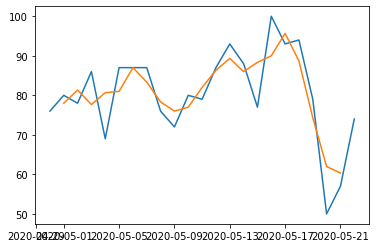

In [11]:
plt.plot(df_interval_no_rolling)
df_interval = df_interval_no_rolling.rolling(3, center=True).mean().dropna()
plt.plot(df_interval)

Retrieve daily data using as less days for the interval as possible

In [12]:
from time import sleep

def mean_query(number, begin, end, topic, geo, cat=0):
    """
    provide multiple queries on the period begin->end. the column topic contains the mean of the queries
    the queries use different interval in order to provide different results
    """
    def dates_to_timeframe(a, b):
        return f"{a.strftime('%Y-%m-%d')} {b.strftime('%Y-%m-%d')}"
    
    def timeframe_iterator():
        """
        yield different timeframes such that [begin, end] is always in the timeframe provided
        uses the closest dates possible to provide the right number of timeframe
        """
        # maximum date allowed for google trends
        max_end = datetime.datetime.today() - datetime.timedelta(days=4)
        lag = int(np.ceil(np.sqrt(number)))
        max_end_lag = (max_end - end).days + 1
        
        # compute possible end and corresponding beginning
        if lag > max_end_lag:
            lag_end = max_end_lag
            lag_begin = int(np.ceil(number / lag_end))
        else:
            lag_begin = lag
            lag_end = lag
            
        # yield timeframes
        for i in range(lag_begin):
            for j in range(lag_end):
                begin_tf = begin - datetime.timedelta(days=i)
                end_tf = end + datetime.timedelta(days=j)
                yield dates_to_timeframe(begin_tf, end_tf)
    
    df_tot = pd.DataFrame()
    cnt = 0
    pytrends = TrendReq(retries=2, backoff_factor=0.1)
    for k, timeframe in enumerate(timeframe_iterator()):
        done = False
        print(f"timeframe= {timeframe} ({k+1}/{number})")
        while not done:
            try:
                pytrends.build_payload([topic], timeframe=timeframe, geo=geo, cat=cat)
                df = pytrends.interest_over_time()
                done = True
            except:
                sleep(10 + 10 * np.random.random())
        df = df[begin:end]
        sleep(1 + np.random.random())
        if 100 not in df[topic]:
            df[topic] = df[topic] * 100 / df[topic].max()
        df_tot[f"{topic}_{cnt}"] = df[topic]
        cnt += 1
        if cnt >= number:
            df_tot[topic_code] = df_tot.mean(axis=1)
            df_tot[topic_code] = 100 * df_tot[topic_code] / df_tot[topic_code].max()
            return df_tot

begin = datetime.datetime.strptime("2020-04-25", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-05-26", "%Y-%m-%d")
df_interval = mean_query(100, begin, end, topic_code, geo)

timeframe= 2020-04-25 2020-05-26 (1/100)
timeframe= 2020-04-25 2020-05-27 (2/100)
timeframe= 2020-04-25 2020-05-28 (3/100)
timeframe= 2020-04-25 2020-05-29 (4/100)
timeframe= 2020-04-25 2020-05-30 (5/100)
timeframe= 2020-04-25 2020-05-31 (6/100)
timeframe= 2020-04-25 2020-06-01 (7/100)
timeframe= 2020-04-25 2020-06-02 (8/100)
timeframe= 2020-04-25 2020-06-03 (9/100)
timeframe= 2020-04-25 2020-06-04 (10/100)
timeframe= 2020-04-24 2020-05-26 (11/100)
timeframe= 2020-04-24 2020-05-27 (12/100)
timeframe= 2020-04-24 2020-05-28 (13/100)
timeframe= 2020-04-24 2020-05-29 (14/100)
timeframe= 2020-04-24 2020-05-30 (15/100)
timeframe= 2020-04-24 2020-05-31 (16/100)
timeframe= 2020-04-24 2020-06-01 (17/100)
timeframe= 2020-04-24 2020-06-02 (18/100)
timeframe= 2020-04-24 2020-06-03 (19/100)
timeframe= 2020-04-24 2020-06-04 (20/100)
timeframe= 2020-04-23 2020-05-26 (21/100)
timeframe= 2020-04-23 2020-05-27 (22/100)
timeframe= 2020-04-23 2020-05-28 (23/100)
timeframe= 2020-04-23 2020-05-29 (24/100)
t

In [13]:
df_interval

,/m/01b_06_0,/m/01b_06_1,/m/01b_06_2,/m/01b_06_3,/m/01b_06_4,/m/01b_06_5,/m/01b_06_6,/m/01b_06_7,/m/01b_06_8,/m/01b_06_9,...,/m/01b_06_91,/m/01b_06_92,/m/01b_06_93,/m/01b_06_94,/m/01b_06_95,/m/01b_06_96,/m/01b_06_97,/m/01b_06_98,/m/01b_06_99,/m/01b_06
date,,,,,,,,,,,,,,,,,,,,,
2020-04-25,94.0,86.0,91.0,74.0,84.0,72.0,88.0,70.0,100.0,76.0,...,73.913043,78.082192,69.318182,93.506494,79.518072,78.048780,79.411765,68.085106,79.775281,86.377243
2020-04-26,90.0,76.0,90.0,96.0,82.0,100.0,83.0,100.0,96.0,86.0,...,98.913043,97.260274,100.000000,88.311688,96.385542,85.365854,94.117647,93.617021,87.640449,97.228145
2020-04-27,89.0,59.0,83.0,85.0,89.0,74.0,77.0,81.0,66.0,78.0,...,80.434783,84.931507,81.818182,84.415584,89.156627,74.390244,83.823529,84.042553,83.146067,88.331269
2020-04-28,80.0,66.0,87.0,82.0,74.0,61.0,81.0,60.0,70.0,76.0,...,63.043478,97.260274,67.045455,100.000000,93.975904,92.682927,83.823529,70.212766,69.662921,87.405334
2020-04-29,96.0,91.0,82.0,90.0,91.0,62.0,77.0,70.0,81.0,87.0,...,65.217391,86.301370,77.272727,92.207792,84.337349,75.609756,86.764706,75.531915,84.269663,88.012931
2020-04-30,92.0,77.0,82.0,88.0,89.0,61.0,89.0,65.0,65.0,85.0,...,81.521739,94.520548,80.681818,81.818182,87.951807,84.146341,88.235294,72.340426,80.898876,90.855381
2020-05-01,85.0,69.0,80.0,89.0,91.0,57.0,83.0,58.0,60.0,83.0,...,67.391304,89.041096,75.000000,84.415584,79.518072,76.829268,83.823529,68.085106,75.280899,86.015154
2020-05-02,81.0,68.0,84.0,84.0,82.0,52.0,81.0,65.0,65.0,78.0,...,60.869565,83.561644,69.318182,71.428571,75.903614,74.390244,66.176471,68.085106,76.404494,83.811446
2020-05-03,96.0,89.0,84.0,83.0,84.0,59.0,80.0,86.0,96.0,91.0,...,100.000000,91.780822,79.545455,98.701299,100.000000,95.121951,92.647059,73.404255,85.393258,95.247401


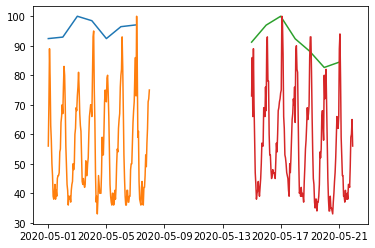

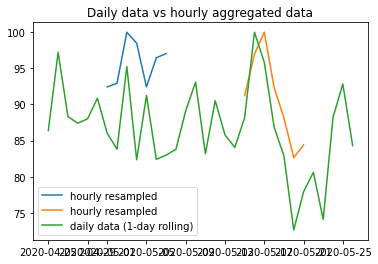

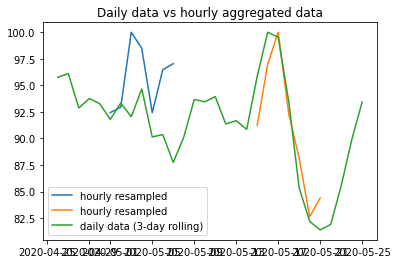

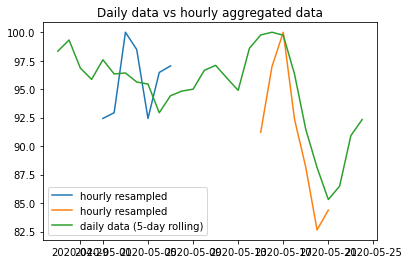

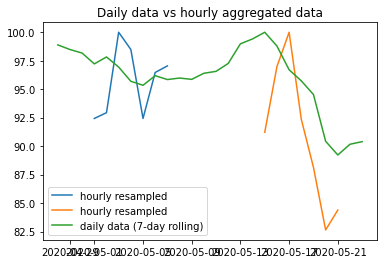

In [14]:
df_1_agg = df_1[topic_code].resample('D').mean()
df_1_agg = df_1_agg * 100 / df_1_agg.max()
df_2_agg = df_2[topic_code].resample('D').mean()
df_2_agg = df_2_agg * 100 / df_2_agg.max()
plt.figure()
plt.plot(df_1_agg)
plt.plot(df_1[topic_code])
plt.plot(df_2_agg)
plt.plot(df_2[topic_code])
plt.show()

for i in [1, 3, 5, 7]:
    df = df_interval_no_rolling.rolling(i, center=True).mean().dropna()
    df = df * 100 / df.max()
    plt.figure()
    plt.plot(df_1_agg, label="hourly resampled")
    plt.plot(df_2_agg, label="hourly resampled")
    rolled_after = df_interval[topic_code].rolling(i, center=True).mean().dropna()
    rolled_after = rolled_after * 100 / rolled_after.max()
    plt.plot(rolled_after, label=f"daily data ({i}-day rolling)")
    plt.legend(loc='lower left')
    plt.title("Daily data vs hourly aggregated data")
    plt.show()

In [15]:
print("intersect 1: ratio hourly/daily")
intersect_1 = df_1_agg.index.intersection(df_interval.index)
scaling_1 = []
for date in intersect_1:
    scaling = df_1_agg.loc[date] / df_interval.loc[date]
    scaling_1.append(scaling)
    print(f"  {date.date()}: {scaling}")
print("mean value of ",np.mean(scaling_1), "\n")
    
print("intersect 2: ratio hourly/daily")
intersect_2 = df_2_agg.index.intersection(df_interval.index)
scaling_2 = []
for date in intersect_2:
    scaling = df_2_agg.loc[date] / df_interval.loc[date]
    scaling_2.append(scaling)
    print(f"  {date.date()}: {scaling}")
print("mean value of ",np.mean(scaling_2))

intersect 1: ratio hourly/daily
  2020-05-01: /m/01b_06_0     1.087408
/m/01b_06_1     1.339561
/m/01b_06_2     1.155371
/m/01b_06_3     1.038536
/m/01b_06_4     1.015711
                  ...   
/m/01b_06_96    1.203053
/m/01b_06_97    1.102670
/m/01b_06_98    1.357561
/m/01b_06_99    1.227798
/m/01b_06       1.074575
Name: 2020-05-01 00:00:00, Length: 101, dtype: float64
  2020-05-02: /m/01b_06_0     1.147338
/m/01b_06_1     1.366682
/m/01b_06_2     1.106362
/m/01b_06_3     1.106362
/m/01b_06_4     1.133346
                  ...   
/m/01b_06_96    1.249282
/m/01b_06_97    1.404342
/m/01b_06_98    1.364974
/m/01b_06_99    1.216347
/m/01b_06       1.108851
Name: 2020-05-02 00:00:00, Length: 101, dtype: float64
  2020-05-03: /m/01b_06_0     1.041667
/m/01b_06_1     1.123596
/m/01b_06_2     1.190476
/m/01b_06_3     1.204819
/m/01b_06_4     1.190476
                  ...   
/m/01b_06_96    1.051282
/m/01b_06_97    1.079365
/m/01b_06_98    1.362319
/m/01b_06_99    1.171053
/m/01b_06       

# Daily trends

In [67]:
data_daily_dir = "../data/trends/collect_daily"
data_hourly_dir = "../data/trends/collect"
data_model_dir = "../data/trends/model"
plot_dir = "../plot/trends"
topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    'Toux': '/m/01b_21',
    #'Coronavirus': '/m/01cpyy'
}
geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-D': "Bourgogne-Franche-Comté",
    'FR-E': 'Bretagne',
    'FR-F': 'Centre-Val de Loire',
    'FR-G': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-H': 'Corse',
    'FR-I': "Bourgogne-Franche-Comté",
    'FR-J': 'Ile-de-France',
    'FR-K': 'Languedoc-Roussillon-Midi-Pyrénées',
    'FR-L': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-M': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-N': 'Languedoc-Roussillon-Midi-Pyrénées',
    'FR-O': 'Nord-Pas-de-Calais-Picardie',
    'FR-P': "Normandie",
    'FR-Q': "Normandie",
    'FR-R': 'Pays de la Loire',
    'FR-S': 'Nord-Pas-de-Calais-Picardie',
    'FR-T': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-U': "Provence-Alpes-Côte d'Azur",
    'FR-V': "Auvergne-Rhône-Alpes"
}

In [68]:
date_parser = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
df_hourly = {geo: {name: pd.read_csv(f"{data_hourly_dir}/{geo}-{name}.csv", parse_dates=['date'], date_parser=date_parser).set_index('date') for name in topics} for geo in geocodes}

# Download daily data as dataframes

In [69]:
date_parser = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")
df_daily = {geo : {} for geo in geocodes}  # stores as a dict of dict of list of pandas dataframe
# format: {geo: {topic: [df_daily_1, df_daily_2, ...]}}
pattern = "([A-Z]{2}(?:-[A-Z])?)-(\D*)-(\d{4}-\d{2}-\d{2})-(\d{4}-\d{2}-\d{2})\.csv"
for file in sorted(os.listdir(data_daily_dir)):
    if not os.path.isfile(os.path.join(data_daily_dir, file)):
        continue  # look only at the files
    search_obj = re.search(pattern, file)
    geo, topic, begin, end = (search_obj.group(i) for i in range(1,5))
    if topic in topics:  # take only the topics specified
        code = topics[topic]
        try:
            df = pd.read_csv(f"{data_daily_dir}/{file}", parse_dates=['date'], date_parser=date_parser).set_index('date')
        except ValueError:  # the first column, date, has no name
            df = pd.read_csv(f"{data_daily_dir}/{file}").rename(columns={"Unnamed: 0": 'date'})
            df.to_csv(f"{data_daily_dir}/{file}", index=False)
            df = pd.read_csv(f"{data_daily_dir}/{file}", parse_dates=['date'], date_parser=date_parser).set_index('date')
        #df = df[[code]]
        df_daily[geo][topic] = df_daily[geo].get(topic, []) + [df]

In [30]:
plt.figure()
for df in df_daily['BE']['Respiration']:
    plt.plot(df)
plt.show()

KeyError: 'Respiration'

<Figure size 432x288 with 0 Axes>

# Merge hourly and daily dataframes to form final dataset

Plot the dataframes with a correct format for the dates

In [31]:
def plot_trends(df_plot, topic_code, show=True):
    fig = plt.figure()
    if isinstance(df_plot, list):
        list_df = df_plot
    else:
        list_df = [df_plot]
    for df in list_df:
        df_plot = 100 * df[[topic_code]] / df[[topic_code]].max()
        plt.plot(df_plot, label="hourly data")
    ax = fig.axes[0]
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    # set formatter
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    # set font and rotation for date tick labels
    plt.gcf().autofmt_xdate()
    plt.grid()
    if show:
        plt.show()
    return fig

In [60]:
def rescale_batch(df_left, df_right, df_daily, overlap_max=30, rolling=7, overlap_min=3, drop=True):
    """
    rescale a left and a right batch with a hole in between, covered by df_daily
    :param df_left: DataFrame on the left interval
    :param df_right: DataFrame on the right interval
    :param df_daily: DataFrame with data between df_left and df_right, used for the merge
    :param overlap_max: maximum number of datapoints used for the overlap
    :param rolling: rolling average on the df_daily data
    :param overlap_min: minimum number of points on the intersection allowed to accept a rolling average. 
        If the rolling average provide less points, df_daily is used instead of the rolling data.
    :param drop: whether to drop preferabily the df_daily data on the interval or not
    :return batch_rescaled: DataFrame of data between df_left.min and df_right.max
    """
    if drop:
        drop = ['right', 'left']
    else:
        drop = [None, None]
    
    daily_rolling = df_daily.rolling(rolling, center=True).mean().dropna()
    daily_rolling = 100 * daily_rolling / daily_rolling.max()
    overlap = df_left.index.intersection(daily_rolling.index)
    overlap_right = daily_rolling.index.intersection(df_right.index)
    #print(len(overlap))
    #print(len(overlap_right))
    if len(overlap) < overlap_min or len(overlap_right) < overlap_min:
        overlap = df_left.index.intersection(df_daily.index)
        daily_used = df_daily
    else:
        daily_used = daily_rolling
        
    if len(overlap) > overlap_max:
        overlap = overlap[-overlap_max:]
    overlap_len = len(overlap)
    daily_used[daily_used < 0.01] = 0
    #print("overlap left len", overlap_len)
    #print("left")
    #plot_trends(df_left, df_left.columns[0])
    #print("daily")
    #plot_trends(daily_used, df_left.columns[0])
    batch_rescaled = merge_trends_batches(df_left, daily_used[overlap.min():], overlap_len, topic_code, 
                                          isHour=False, verbose=False, drop=drop[0])
    batch_rescaled = 100 * batch_rescaled / batch_rescaled.max()
    overlap = batch_rescaled.index.intersection(df_right.index)
    if len(overlap) > overlap_max:
        overlap = overlap[:overlap_max]
    overlap_len = len(overlap)
    #print("overlap right len", overlap_len)
    #print("temporary merge")
    #plot_trends(batch_rescaled, batch_rescaled.columns[0])
    #print("right")
    #plot_trends(df_right, df_left.columns[0])
    batch_rescaled = merge_trends_batches(batch_rescaled[:overlap.max()], df_right, overlap_len, topic_code, 
                                          isHour=False, verbose=False, drop=drop[1])
    batch_rescaled = 100 * batch_rescaled / batch_rescaled.max()
    #print("merge final")
    #plot_trends(batch_rescaled, batch_rescaled.columns[0])
    return batch_rescaled

def merge_hourly_daily(list_df_hourly, list_df_daily, drop, add_daily_end= True):
    """
    merge the hourly (deterministic) aggregated batches, using the daily (stochastic) batches on the missing interval
    :param list_df_hourly: sorted list of deterministic DataFrame, having a daily index
    :param list_df_daily: list of stochastic DataFrame, having data on the missing interval of list_df_hourly
    :param drop: whether to drop the stochastic data preferably or not
    :param add_daily_end: if True, add daily data data at the end if the max date of daily data > max date of hourly data
    :return df: merged DataFrame
    """
    def find_largest_intersection(df_a, df_b):
        """
        find daily dataframe with the largest intersection on df_a and df_b
        """
        best_inter = 0
        best_df = None
        for df_candidate in list_df_daily:
            intersection_left = len(df_a.index.intersection(df_candidate.index))
            intersection_right = len(df_b.index.intersection(df_candidate.index))
            inter = min(intersection_left, intersection_right)
            if inter > best_inter:
                best_df = df_candidate
                best_inter = inter
        if best_df is None:
            raise Exception("No dataframe could be found for the gap")
        return best_df
    
    for i, df_right in enumerate(list_df_hourly):
        if i == 0:
            df = df_right
        else:
            df_daily = find_largest_intersection(df, df_right)
            df = rescale_batch(df, df_right, df_daily, drop=drop)
    
    if add_daily_end:  # attempt to add daily data at the end
        daily_possible = [df_daily for df_daily in list_df_daily if df_daily.index.max() > df.index.max()]
        if len(daily_possible) != 0:
            column = df.columns[0]
            while len(daily_possible) > 0:
                candidate = max(daily_possible, key=lambda df_daily: df_daily.index.intersection(df.index))
                overlap_len = len(df.index.intersection(candidate.index))
                if overlap_len == 0:  # not possible to add the data since there is not overlap
                    break
                df = merge_trends_batches(df, candidate, overlap_len, column, 
                                          isHour=False, verbose=False, drop='right')
                df = df * 100 / df.max()
                daily_possible = [df_daily for df_daily in daily_possible if df_daily.index.max() > df.index.max()]
    return df
    
    """
    # merge the first 2 batches
    df_left = list_df_hourly[0]
    df_right = list_df_hourly[1]
    df_daily = list_df_daily[0]
    df = rescale_batch(df_left, df_right, df_daily, drop=drop)
    # merge third until last batch (not included)
    j = 0
    for i in range(2, len(list_df_hourly)):
        df_right = list_df_hourly[i]
        has_intersection = False
        # check for overlap
        while not has_intersection:
            intersection_left = len(df.index.intersection(df_daily.index))
            intersection_right = len(df_right.index.intersection(df_daily.index))
            #print(f"intersection left {intersection_left}")
            #print(f"intersection right {intersection_right}")
            if intersection_left < 1 or intersection_right < 1:
                # goes to the next daily batch
                j += 1
                df_daily = list_df_daily[j]
            else:
                has_intersection = True
        df = rescale_batch(df, df_right, df_daily, drop=drop)
    if add_daily_end:  # attempt to add daily data at the end
        column = df.columns[0]
        while j < len(list_df_daily):
            df_daily = list_df_daily[j]
            if df.index.max() < df_daily.index.max():
                overlap_len = len(df.index.intersection(df_daily.index))
                df = merge_trends_batches(df, df_daily, overlap_len, column, 
                                          isHour=False, verbose=False, drop='right')
                df = df * 100 / df.max()
            j += 1
    return df
    """

def drop_uncomplete_days(list_df):
    """
    filter a list of hourly dataframes, to return a list where each dataframe:
    - begins at MM-DD-0h
    - ends at MM-DD-23h
    - contains at least 3 days of data
    - has at least 3 points of value > 30
    """
    result = []
    for i in range(len(list_df)):
        df = list_df[i]
        old_begin, old_end = df.index.min(), df.index.max()
        new_begin = old_begin + datetime.timedelta(hours=((24 - old_begin.hour) % 24))  # MM-DD-0h
        new_end = old_end - datetime.timedelta(hours=((old_end.hour + 1) % 24))  # MM-DD-23h
        cur_df = df[new_begin:new_end]
        # check for chain of zeros at the beginning and the end
        has_zero = True
        hours_drop = 10
        delta = datetime.timedelta(hours=hours_drop)
        while has_zero and new_begin < new_end:  # zeros at the beginning
            if cur_df[:new_begin + delta].sum()[0] == 0:
                new_begin += datetime.timedelta(days=1)
            else:
                has_zero = False
                
        has_zero = True
        while has_zero and new_begin < new_end:  # zeros at the end
            if cur_df[new_end - delta:].sum()[0] == 0:
                new_end -= datetime.timedelta(days=1)
            else:
                has_zero = False
        # new dates for the dataframe
        cur_df = cur_df[new_begin:new_end]
        # check if the resulting dataframe can be added
        if not cur_df.empty and (new_end-new_begin).days >= 4:# and len(np.where(cur_df > 30)[0]) > 3:
            result.append(cur_df)
    return result

FR-I
before drop uncomplete


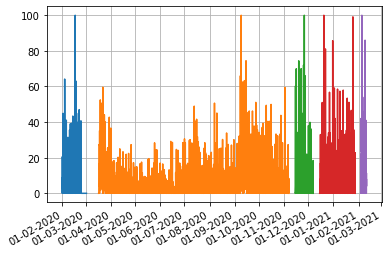

after drop uncomplete: hourly trends aggregated


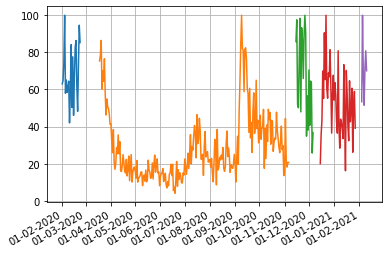

daily trends


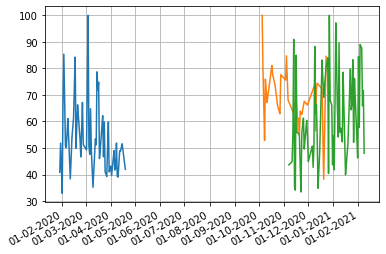

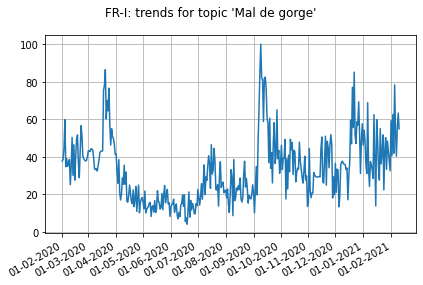

In [70]:
geocodes = {
    #'BE': "Belgique",
    #'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    #'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    #'FR-C': "Auvergne-Rhône-Alpes",
    #'FR-D': "Bourgogne-Franche-Comté",
    #'FR-E': 'Bretagne',
    #'FR-F': 'Centre-Val de Loire',
    #'FR-G': "Alsace-Champagne-Ardenne-Lorraine",
    #'FR-H': 'Corse',
    'FR-I': "Bourgogne-Franche-Comté",
    #'FR-J': 'Ile-de-France',
    #'FR-K': 'Languedoc-Roussillon-Midi-Pyrénées',
    #'FR-L': "Aquitaine-Limousin-Poitou-Charentes",
    #'FR-M': "Alsace-Champagne-Ardenne-Lorraine",
    #'FR-N': 'Languedoc-Roussillon-Midi-Pyrénées',
    #'FR-O': 'Nord-Pas-de-Calais-Picardie',
    #'FR-P': "Normandie",
    #'FR-Q': "Normandie",
    #'FR-R': 'Pays de la Loire',
    #'FR-S': 'Nord-Pas-de-Calais-Picardie',
    #'FR-T': "Aquitaine-Limousin-Poitou-Charentes",
    #'FR-U': "Provence-Alpes-Côte d'Azur",
    #'FR-V': "Auvergne-Rhône-Alpes"
}
complete_df = {geo : {} for geo in geocodes}
for geo, topic_dic in df_hourly.items():
    if geo not in geocodes:
        continue
    print(geo)
    for topic, trends_hourly in topic_dic.items():
        if geo != 'FR-I' or topic != 'Mal de gorge':
            continue
        topic_code = topics[topic]
        list_df_hourly = scale_df(trends_hourly, topic_code)
        list_df_daily = deepcopy(df_daily[geo][topic])
        print("before drop uncomplete")
        plot_trends(list_df_hourly, topic_code)
        list_df_hourly = drop_uncomplete_days(list_df_hourly)
        list_df_hourly = [df.resample('D').mean() for df in list_df_hourly]
        #for i in range(len(list_df_hourly)):
        #    list_df_hourly[i] = list_df_hourly[i].rolling(7, center=True).mean().dropna()
        #    list_df_hourly[i] = 100 * list_df_hourly[i] / list_df_hourly[i].max()
        print("after drop uncomplete: hourly trends aggregated")
        plot_trends(list_df_hourly, topic_code)
        print("daily trends")
        for i in range(len(list_df_daily)):
            list_df_daily[i][topic_code] = list_df_daily[i].replace(0, np.nan).mean(axis=1).interpolate()
            list_df_daily[i] = 100 * list_df_daily[i][[topic_code]] / list_df_daily[i][[topic_code]].max()
        plot_trends(list_df_daily, topic_code)
        complete_df[geo][topic] = merge_hourly_daily(list_df_hourly, list_df_daily, drop=True)
        #complete_df[geo][topic] = complete_df[geo][topic].rolling(7, center=True).mean().dropna()
        fig = plot_trends(complete_df[geo][topic], topic_code, show=False)
        fig.suptitle(f"{geo}: trends for topic '{topic}'")
        fig.tight_layout()
        #fig.savefig(f"{plot_dir}/{geo}-{topic}", facecolor='white')
        plt.show()

In [57]:
my_begin = datetime.datetime.strptime("2020-02-01","%Y-%m-%d")
my_end = datetime.datetime.strptime("2020-12-25","%Y-%m-%d")
print((my_end - my_begin).days + 1)
#print(complete_df['FR-D']['Agueusie'])
"""
topic_name = 'Coronavirus'
topic_code = topics[topic_name]
plot_trends(complete_df['BE'][topic_name], topic_code)
plot_trends(list_df_hourly, topic_code)
"""

329


"\ntopic_name = 'Coronavirus'\ntopic_code = topics[topic_name]\nplot_trends(complete_df['BE'][topic_name], topic_code)\nplot_trends(list_df_hourly, topic_code)\n"

## Save the dataframes into the model directory

In [19]:
for geo, trends_dic in complete_df.items():
    for topic_name, df in trends_dic.items():
        filename = f"{data_model_dir}/{geo}-{topic_name}.csv"
        df.to_csv(filename)

# Correct id of the batches

In [ ]:
def correct_batch_id(topic_title:str, topic_code:str, geo:str) -> pd.DataFrame:
    """
    correct the batch_id of the batch collected
    a batch_id must be negative if either
        - the data could not be collected on the given period
        - there is not less than 3 datapoints with value > 10
    :param topic_title: title of the topic to look at
    :param topic_code: code of the topic to look at
    :param geo: geocode of the dataframe to look at
    :return final_df: dataframe where the batch_id is set to negative if needed. This dataframe is saved in
        data/trends/collect as a csv file
    """
    data_dir = "../data/trends/collect"
    csv_file = f'{data_dir}/{geo}-{topic_title}.csv'
    date_parser = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    df = pd.read_csv(csv_file, parse_dates=['date'], date_parser=date_parser).set_index('date')
    list_batches = df.batch_id.unique()
    
    final_df = pd.DataFrame()
    cur_batch_id = 0  # always positive
    previous_df_batch = None
    previous_batch_id = None
    
    for i, batch_id in enumerate(list_batches):
        df_batch = df[df['batch_id'] == batch_id]
        # a valid batch must have at least more than 3 values above 10
        if len(np.where(df_batch[topic_code] > 10)[0]) <= 3:
            df_batch = df_batch.assign(batch_id=-cur_batch_id)
            batch_id = -cur_batch_id
        else:  # the batch is valid and must have a positive batch id
            df_batch = df_batch.assign(batch_id=cur_batch_id)
            batch_id = cur_batch_id
            
        # there is a gap between this batch and the previous one and the two batches don't have a negative batch_id
        if (i != 0 and len(previous_df_batch.index.intersection(df_batch.index)) == 0 
            and batch_id > 0 and previous_batch_id > 0):
            min_date = previous_df_batch.index.max()
            max_date = df_batch.index.min()
            days = pd.date_range(min_date, max_date, freq='H')
            data = np.zeros(len(days))
            batch_id_vector = [-cur_batch_id for i in range(len(days))]
            df_zero = pd.DataFrame({'date': days, topic_code: data, 'batch_id': batch_id_vector})
            df_zero = df_zero.set_index('date')
            cur_batch_id += 1  # count as if 2 batches were added
            df_batch = df_zero.append(df_batch)
            
        previous_df_batch = df_batch
        previous_batch_id = batch_id
        final_df = final_df.append(df_batch)
        cur_batch_id += 1
    final_df.to_csv(csv_file, index=True)
    return final_df

In [ ]:
for geo in geocodes:
    for topic_title, topic_code in topics.items():
        correct_batch_id(topic_title, topic_code, geo)

In [ ]:
correct_batch_id('Agueusie', '/m/05sfr2', 'FR-A')

In [46]:
for geo in geocodes:
    for topic_title, topic_code in topics.items():
        correct_batch_id(topic_title, topic_code, geo)

In [221]:
correct_batch_id('Agueusie', '/m/05sfr2', 'FR-A')

,/m/05sfr2,batch_id
date,,
2020-02-01 00:00:00,0,0
2020-02-01 01:00:00,0,0
2020-02-01 02:00:00,0,0
2020-02-01 03:00:00,0,0
2020-02-01 04:00:00,0,0
...,...,...
2021-01-24 19:00:00,13,59
2021-01-24 20:00:00,0,59
2021-01-24 21:00:00,0,59
